In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

import pandas as pd
import numpy as np
import os
import glob

### *functions*

In [ ]:
def get_label_from_filename(filename): 
    if "Phantom" in filename: return "Phantom"
    elif "Ruko_F11_Pro" in filename: return "Ruko_F11_Pro"
    elif "Ruko_F11_base" in filename: return "Ruko_F11_base"
    elif "Mavic_Air_2_" in filename: return "Mavic_Air_2"
    elif "Mavic_Air_2S" in filename: return "Mavic_Air_2S"
    elif "DeerC" in filename: return "DeerC_DE2"
    elif "Mini_SE" in filename: return "Mini_SE"
    elif "Holystone_HS100" in filename: return "Holystone_HS100"
    elif "None" in filename: return "None"
    else: return "UNKNOWN_LABEL"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result

    

### *variables*

In [168]:
# Path to your IQ files
data_dir = "./data/"
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 100

# Example: sample windows with 50% overlap
# window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 2048 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 8192 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 16_384 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 32_768 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)

# step = 8192
# step = 4096
# step = 2048
step = 1024
# step = 512

['./data/iqSamples_Ruko_F11_Pro.csv', './data/iqSamples_Phantom.csv', './data/iqSamples_Mini_SE.csv', './data/iqSamples_Mavic_Air_2_.csv', './data/iqSamples_Holystone_HS100.csv', './data/iqSamples_Ruko_F11_base.csv', './data/iqSamples_Mavic_Air_2S.csv', './data/iqSamples_None.csv', './data/iqSamples_DeerC_DE2.csv']


### *Reading in files*

In [ ]:
X = []
y = []

segments = []
labels = []


# create an array of dataframes.
# each dataframe containing iq samples from one file
for file in drone_csv_files:
    print("File: ", file)
    label = get_label_from_filename(file)
    # print("Label: ", label)
    iq = load_iq(file, chunk_size, every_n_rows)  # shape (N, 2)
    # print("File:\n", iq)
    for i in range(0, len(iq)-window_size, step):
        window = iq[i:i+window_size].flatten()
        segments.append(window)
        labels.append(label)
    # print("Segments:\n", segments)
    # print("Labels:\n", labels)

X = np.array(segments)
y = np.array(labels)

File:  ./data/iqSamples_Ruko_F11_Pro.csv
File:  ./data/iqSamples_Phantom.csv
File:  ./data/iqSamples_Mini_SE.csv
File:  ./data/iqSamples_Mavic_Air_2_.csv
File:  ./data/iqSamples_Holystone_HS100.csv
File:  ./data/iqSamples_Ruko_F11_base.csv
File:  ./data/iqSamples_Mavic_Air_2S.csv
File:  ./data/iqSamples_None.csv
File:  ./data/iqSamples_DeerC_DE2.csv


### *Displaying things*

In [ ]:
print("Segments:")
print("Shape: ", X.shape)
print(X)
print("-------------------------------------------------------------------")
print("Labels:")
print("Shape: ", y.shape)
print(y)

Segments:
Shape:  (1530, 32768)
[[-3.3840e+03 -5.6930e+03 -1.8970e+03 ...  3.7900e+02 -2.2100e+02
   3.1000e+01]
 [-2.5300e+02  1.2600e+02 -2.5300e+02 ...  6.3000e+01 -7.9000e+02
  -4.7400e+02]
 [-9.4000e+01  6.3000e+01 -3.4700e+02 ...  1.5814e+04 -4.4270e+03
   1.2682e+04]
 ...
 [ 1.7000e+01  3.4000e+01  0.0000e+00 ... -2.4910e+04 -1.3048e+04
   2.1351e+04]
 [-3.4000e+01  3.0900e+02  1.0300e+02 ... -8.5000e+01 -1.7100e+02
   1.0300e+02]
 [ 2.4927e+04 -5.4490e+03 -2.1042e+04 ...  5.1000e+01  3.4000e+01
   6.8000e+01]]
-------------------------------------------------------------------
Labels:
Shape:  (1530,)
['Ruko_F11_Pro' 'Ruko_F11_Pro' 'Ruko_F11_Pro' ... 'DeerC' 'DeerC' 'DeerC']


In [ ]:
# print("labels: ")
# print(np.unique(y))
# print()

for sample, label in zip(X, np.unique(y)): 
    print("X feature:\n", sample)
    print("IQ samples in X feature: ", int(sample.size / 2))
    print("y label: ", label)
    print('------------------------------------------------------')

X feature:
 [-3384. -5693. -1897. ...   379.  -221.    31.]
IQ samples in X feature:  16384
y label:  DeerC
------------------------------------------------------
X feature:
 [-253.  126. -253. ...   63. -790. -474.]
IQ samples in X feature:  16384
y label:  Mavic_Air_2
------------------------------------------------------
X feature:
 [  -94.    63.  -347. ... 15814. -4427. 12682.]
IQ samples in X feature:  16384
y label:  Mavic_Air_2S
------------------------------------------------------
X feature:
 [  31.  379.  -31. ... -316.  284.    0.]
IQ samples in X feature:  16384
y label:  Mini_SE
------------------------------------------------------
X feature:
 [-14770.   3953.  -2720. ...    158.   -284.   -189.]
IQ samples in X feature:  16384
y label:  None
------------------------------------------------------
X feature:
 [-316. -253. -569. ...    0. -189.  189.]
IQ samples in X feature:  16384
y label:  Phantom
------------------------------------------------------
X feature:
 [-158.

### *Training, fitting & predicting*

In [ ]:
# Train/test split (e.g. 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Fit and predict
SVCModel = SVC(kernel='rbf', C=10, gamma='scale', max_iter=160_000)  # tweak C/gamma as needed
SVCModel.fit(X_train, y_train)
y_pred = SVCModel.predict(X_test)


### *Metrics*

In [ ]:
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
perc_accuracy = accuracy * 100
print(cr)
print(f"Accuracy: {perc_accuracy:.2f}%")
print()
print(cm)

               precision    recall  f1-score   support

        DeerC       0.49      0.45      0.47        38
  Mavic_Air_2       0.00      0.00      0.00        37
 Mavic_Air_2S       0.00      0.00      0.00        38
      Mini_SE       0.51      0.61      0.55        38
         None       0.81      1.00      0.89        38
      Phantom       0.32      0.16      0.21        38
 Ruko_F11_Pro       0.63      0.68      0.66        38
Ruko_F11_base       0.38      1.00      0.55        38
UNKNOWN_LABEL       0.00      0.00      0.00         3

     accuracy                           0.48       306
    macro avg       0.35      0.43      0.37       306
 weighted avg       0.39      0.48      0.41       306

Accuracy: 48.37%

[[17  3  0  5  0 10  3  0  0]
 [ 0  0  0  0  4  0  0 33  0]
 [ 0 11  0  0  0  0  0 27  0]
 [ 7  0  0 23  5  2  1  0  0]
 [ 0  0  0  0 38  0  0  0  0]
 [ 4  0  0 17  0  6 11  0  0]
 [ 7  4  0  0  0  1 26  0  0]
 [ 0  0  0  0  0  0  0 38  0]
 [ 0  0  0  0  0  0  0  

/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/carlos_1/Documents/GitHub/iq-classification-classical-models/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

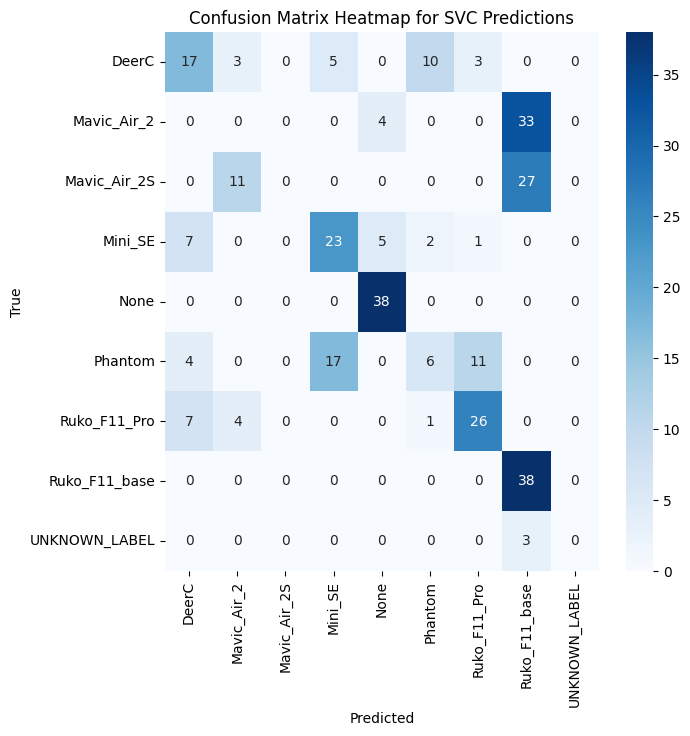

In [ ]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

plt.show()


In [ ]:
%%script false --no-raise-error # uncomment this to skip execution of this cell

# Display the decision boundary with training data
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

fig = plot_decision_regions(X_train, y_train, SVCModel, ax = ax[0], zoom_factor=0.5)
ax[0].set_xlabel('In-Phase (I)', fontsize = 14)
ax[0].set_ylabel('Quadrature Phase (Q)', fontsize = 14)
ax[0].set_title('SVC (train)', fontsize = 14)
ax[0].set_xlim(-2.5, 10.5)
ax[0].set_ylim(-2.5, 2.5)

# Display the decision boundary with testing data
fig = plot_decision_regions(X_test, np.ravel(y_test), SVCModel, ax = ax[1], zoom_factor=0.25)
ax[1].set_xlabel('In-Phase (I)', fontsize = 14)
ax[1].set_title('SVC (test)', fontsize = 14)
ax[1].set_xlim(-2.5, 10.5)
ax[1].set_ylim(-2.5, 2.5)

plt.show()